%load_ext autoreload
%autoreload 2

# Tokenizing smiles

In [16]:
import pandas as pd
import torch
from Preprocess.utils import SMILESTokenizerBuilder, RawDataLoader



In [17]:
file_name = "qm9.csv"

# Initialize the data loader with qm9.csv
loader = RawDataLoader(file_name, smiles_column="smiles")

# Create a tokenizer with initial vocabulary of basic elements
initial_vocab = ["C", "N", "O"]
tokenizer = SMILESTokenizerBuilder(vocab_list=initial_vocab)

# Get unique tokens from all SMILES
unique_tokens = tokenizer.tokenize_with_vocab(loader.data, "smiles")
tokenizer.build_vocab_mappings()


Resulting vocabulary after processing all SMILES:
['<SOS>', 'C', 'F', 'H', 'N', 'O', '#', '(', ')', '+', '-', '=', '[', ']', '1', '2', '3', '4', '5', '<EOS>', '<PAD>']

Token's id
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 60, 'C': 10, 'F': 11, 'H': 12, 'N': 13, 'O': 14, '#': 30, '(': 31, ')': 32, '+': 33, '-': 34, '=': 35, '[': 36, ']': 37, '1': 40, '2': 41, '3': 42, '4': 43, '5': 44}

Token statistics
Number of unique tokens found: 21
Tokens Frequency : Counter({'C': 846556, '1': 270020, 'O': 187997, 'N': 139764, '(': 126532, ')': 126532, '2': 121675, '=': 106335, '#': 37027, '3': 34756, '[': 9918, ']': 9918, 'H': 8247, '4': 5186, 'F': 3314, '-': 1808, '+': 1705, '5': 242})


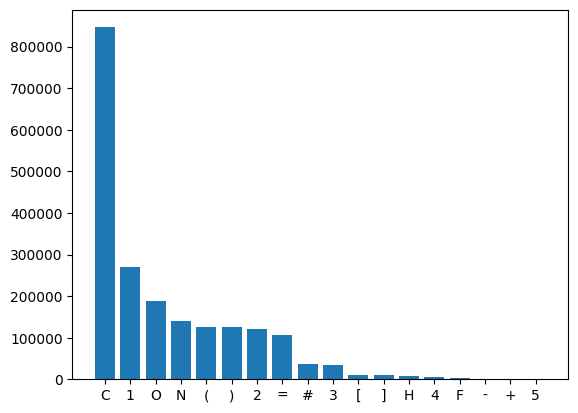

In [18]:
# Print the resulting vocabulary

print("Resulting vocabulary after processing all SMILES:")
print(unique_tokens)

print("\nToken's id")
print(tokenizer.vocab_to_idx)

# Print statistics
print("\nToken statistics")
print(f"Number of unique tokens found: {len(unique_tokens)}")
print(f"Tokens Frequency : {tokenizer.token_counts}")

import matplotlib.pyplot as plt

stats = tokenizer.token_counts
sorted_items = sorted(stats.items(), key=lambda x: x[1], reverse=True)
tokens, counts = zip(*sorted_items)

plt.bar(tokens, counts)
plt.show()

In [62]:
seq_len = 40
smiles_tensor = tokenizer.encode_to_tensor(loader.data, seq_len)
print(f"Tensor shape: {smiles_tensor.shape}")

# Calculate number of zeros (padding) in each sequence
padding_counts = (smiles_tensor == 0).sum(dim=1)

# Find the index of the sequence with minimum padding
min_padding_idx = padding_counts.argmin().item()

# Get the sequence with least padding
least_padded_seq = smiles_tensor[min_padding_idx]

print(f"\nSequence with least padding (index {min_padding_idx}):")
print(f"Sequence: {least_padded_seq.tolist()}")
print(f"Number of padding tokens: {padding_counts[min_padding_idx].item()}")
print(f"Original SMILES: {loader.data.iloc[min_padding_idx]['smiles']}")

# Optional: Show top 5 sequences with least padding
print("\nTop 3 sequences with least padding:")
top_3_indices = padding_counts.argsort()[:3]
for idx in top_5_indices:
    idx_int = idx.item()  # Convert tensor to integer
    seq = smiles_tensor[idx_int]
    print(f"\nIndex {idx_int}:")
    print(f"Sequence: {seq.tolist()}")
    print(f"Padding tokens: {padding_counts[idx_int].item()}")
    print(f"Original SMILES: {loader.data.iloc[idx_int]['smiles']}")

Tensor shape: torch.Size([133885, 40])

Sequence with least padding (index 24869):
Sequence: [1, 10, 40, 31, 35, 14, 32, 36, 13, 12, 37, 10, 31, 35, 14, 32, 36, 13, 12, 37, 10, 31, 35, 14, 32, 36, 13, 12, 37, 40, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of padding tokens: 9
Original SMILES: c1(=O)[nH]c(=O)[nH]c(=O)[nH]1

Top 3 sequences with least padding:

Index 24869:
Sequence: [1, 10, 40, 31, 35, 14, 32, 36, 13, 12, 37, 10, 31, 35, 14, 32, 36, 13, 12, 37, 10, 31, 35, 14, 32, 36, 13, 12, 37, 40, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padding tokens: 9
Original SMILES: c1(=O)[nH]c(=O)[nH]c(=O)[nH]1

Index 54383:
Sequence: [1, 10, 10, 40, 41, 10, 10, 31, 10, 40, 32, 31, 36, 13, 12, 41, 33, 37, 41, 32, 10, 31, 36, 14, 34, 37, 32, 35, 14, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padding tokens: 10
Original SMILES: CC12CC(C1)([NH2+]2)C([O-])=O

Index 54386:
Sequence: [1, 36, 13, 12, 42, 33, 37, 10, 40, 41, 10, 10, 31, 10, 40, 32, 31, 10, 41, 32, 10, 31, 36, 14, 34, 37, 32, 35, 14, 60, 0, 0, 0, 0, 0, 0, 0, 

# Getting Target's 

In [63]:
Y = torch.tensor(loader.data['u298'].values, dtype=torch.float32)
print(Y.shape)
print(Y[12])

torch.Size([133885])
tensor(-119.0479)


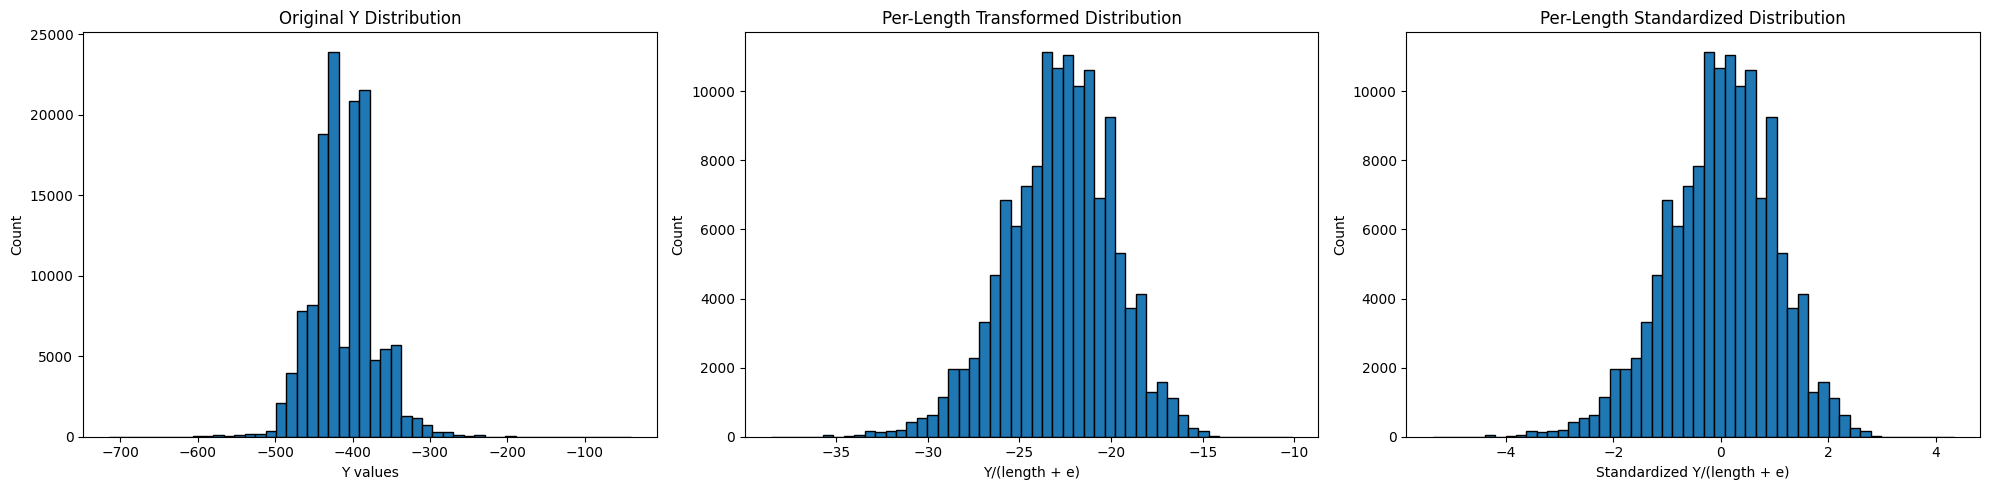


Statistics:

Original Y:
Mean: -411.54
Std: 40.06
Min: -714.56
Max: -40.48

Per-Length Transformed:
Mean: -22.83
Std: 2.93
Min: -38.54
Max: -10.12

Per-Length Standardized:
Mean: 0.00
Std: 1.00
Min: -5.36
Max: 4.33


In [140]:
from Model.TargetTransformer import TargetTransformer

# Initialize transformer
transformer = TargetTransformer()
'''
---------------------------------
        y is tranformed like this ,
n= length of not 'PAD' elements of X
e= normalizer value
    y = y/(n+e)
---------------------------------
'''
# Get transformed values
Y_per_length = transformer.per_length(X, Y, e=1)
Y_per_length_standard = transformer.per_length_standard(X, Y, e=1)

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot original Y distribution
ax1.hist(Y.cpu().numpy(), bins=50, edgecolor='black')
ax1.set_title('Original Y Distribution')
ax1.set_xlabel('Y values')
ax1.set_ylabel('Count')

# Plot per_length distribution
ax2.hist(Y_per_length.cpu().numpy(), bins=50, edgecolor='black')
ax2.set_title('Per-Length Transformed Distribution')
ax2.set_xlabel('Y/(length + e)')
ax2.set_ylabel('Count')

# Plot per_length_standard distribution
ax3.hist(Y_per_length_standard.cpu().numpy(), bins=50, edgecolor='black')
ax3.set_title('Per-Length Standardized Distribution')
ax3.set_xlabel('Standardized Y/(length + e)')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics:")
print("\nOriginal Y:")
print(f"Mean: {Y.mean():.2f}")
print(f"Std: {Y.std():.2f}")
print(f"Min: {Y.min():.2f}")
print(f"Max: {Y.max():.2f}")

print("\nPer-Length Transformed:")
print(f"Mean: {Y_per_length.mean():.2f}")
print(f"Std: {Y_per_length.std():.2f}")
print(f"Min: {Y_per_length.min():.2f}")
print(f"Max: {Y_per_length.max():.2f}")

print("\nPer-Length Standardized:")
print(f"Mean: {Y_per_length_standard.mean():.2f}")
print(f"Std: {Y_per_length_standard.std():.2f}")
print(f"Min: {Y_per_length_standard.min():.2f}")
print(f"Max: {Y_per_length_standard.max():.2f}")

# Creating Model
Model is consists of a Transformer_encoder part to reach latent space and then an MLP to do the Task

In [112]:
from Model.transformer_encoder import TransformerEncoder
from Model.mlp import MLP
from Model.combined_model import CombinedModel
import torch.nn as nn

In [113]:
# Initialize the models
transformer = TransformerEncoder(
    vocab_size=tokenizer.get_vocab_size(),
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    dim_feedforward=512,
    dropout=0.1,
    max_seq_length=seq_len,
    padding_token=0
)

mlp = MLP(
    input_dim=128,
    output_dim=1,
    dims=[256,128,64,32,8,1],
    activations=['leaky_relu', 'leaky_relu', 'tanh','tanh', 'tanh','']
)

model = CombinedModel(transformer , mlp)

In [114]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count total parameters
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

# Optional: Print parameters by layer
print("\nParameters by layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel():,} parameters")

Total trainable parameters: 480,883

Parameters by layer:
transformer.token_embedding.weight: 7,808 parameters
transformer.transformer_encoder.layers.0.self_attn.in_proj_weight: 49,152 parameters
transformer.transformer_encoder.layers.0.self_attn.in_proj_bias: 384 parameters
transformer.transformer_encoder.layers.0.self_attn.out_proj.weight: 16,384 parameters
transformer.transformer_encoder.layers.0.self_attn.out_proj.bias: 128 parameters
transformer.transformer_encoder.layers.0.linear1.weight: 65,536 parameters
transformer.transformer_encoder.layers.0.linear1.bias: 512 parameters
transformer.transformer_encoder.layers.0.linear2.weight: 65,536 parameters
transformer.transformer_encoder.layers.0.linear2.bias: 128 parameters
transformer.transformer_encoder.layers.0.norm1.weight: 128 parameters
transformer.transformer_encoder.layers.0.norm1.bias: 128 parameters
transformer.transformer_encoder.layers.0.norm2.weight: 128 parameters
transformer.transformer_encoder.layers.0.norm2.bias: 128 pa

In [115]:
import torch
from torch.utils.data import DataLoader, random_split
from Model.utils import create_data_loaders
import numpy as np

In [116]:
X = smiles_tensor

Data split statistics:
Total data size: 133885
Subset size (50.0%): 66942
Test selection pool size (40%): 53554

Split sizes:
Training set: 53554
Test set: 13388

Padding statistics per split:
Train set avg padding: 24.09
Test set avg padding: 20.81
Sequence Length Statistics:
Min length: 3
Max length: 18
Mean length: 15.91
Median length: 16.00
Std length: 1.44


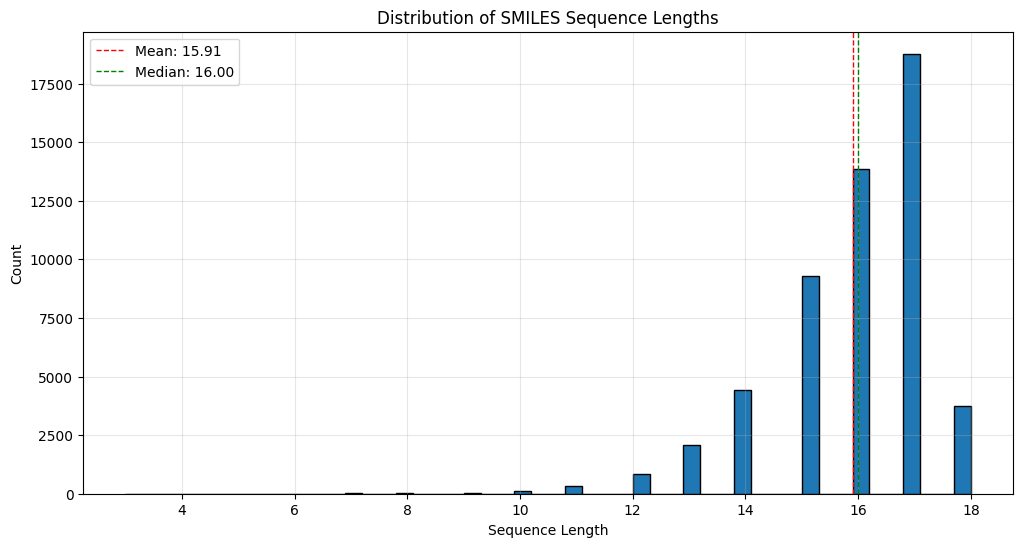


Length Distribution:
Length 1-5: 7 sequences (0.01%)
Length 6-10: 217 sequences (0.41%)
Length 11-15: 16943 sequences (31.64%)
Length 16-20: 36387 sequences (67.94%)
Length 21-25: 0 sequences (0.00%)
Length 26-30: 0 sequences (0.00%)
Length 31-35: 0 sequences (0.00%)
Length 36-40: 0 sequences (0.00%)
Length 41-45: 0 sequences (0.00%)
Length 46-50: 0 sequences (0.00%)

Training Data Statistics:
Total sequences: 53554
Average length: 15.91


In [141]:
# Import the function
from Data.utils import train_x_stats
from Model.utils import create_train_test_loaders
# Create data loaders
torch.manual_seed(42)
np.random.seed(42)

Y = Y_per_length_standard
train_loader, test_loader = create_train_test_loaders(
    X=X,
    Y=Y,
    p=0.5,  # Use 50% of data
    split_ratios=[0.2, 0.8],  # [test, train] ratios
    batch_size=160
)


# Get statistics for training data
train_stats = train_x_stats(train_loader)

# Access specific statistics
print("\nTraining Data Statistics:")
print(f"Total sequences: {train_stats['total_size']}")
print(f"Average length: {train_stats['mean_length']:.2f}")

In [142]:
from Model.utils import create_Incremental_loaders

# Create 4 incremental loaders from your train_loader
loaders = create_Incremental_loaders(
    train_loader=train_loader,
    n=4,  # Create 4 loaders
    batch_size=160  # Optional: specify batch size
)

# Access individual loaders
train_loader1 = loaders[0]  # First quarter (most padding)
train_loader2 = loaders[1]  # Second quarter
train_loader3 = loaders[2]  # Third quarter
train_loader4 = loaders[3]  # Last quarter (least padding)


Loader 1 Statistics:
Size: 13388
Average padding: 26.02

Loader 2 Statistics:
Size: 13388
Average padding: 24.28

Loader 3 Statistics:
Size: 13388
Average padding: 23.32

Loader 4 Statistics:
Size: 13390
Average padding: 22.72


In [148]:
import torch.optim as optim
from Model.trainer import Trainer

# Define loss function
criterion = nn.MSELoss()  # For energy task

# Define optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
)

In [155]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

#setting logd_dir
log_dir='Experiments/experiment1/train_loader1'

# Initialize trainer
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    log_dir=log_dir
)

Using device: cpu
not found directory, creating directory: Experiments/experiment1/train_loader1


In [156]:
# Train the model
from Model.utils import create_train_val_loader

# Create your train and validation loaders
train_loader, val_loader = create_train_val_loader(train_loader1, val_ratio=0.2)

# Train the model
history = trainer.train(train_loader=train_loader,
                        num_epochs=1,
                        scheduler=scheduler,
                        val_loader=val_loader)


Train-Val Split Statistics:
Original train set size: 13388
New train set size: 10711
Validation set size: 2677

Padding statistics per split:
Train set avg padding: 26.02
Val set avg padding: 26.02
Epoch: 1/1 Batch: 0/67 Loss: 1.0438
Epoch: 1/1 Batch: 40/67 Loss: 1.0764
Epoch: 1/1 Train Loss: 1.0920 Time: 88.63s
Epoch: 1/1 Validation Loss: 451.9610


In [ ]:
# After training, you can evaluate on validation set if needed
val_loss = trainer.evaluate(val_loader)
print(f"Validation Loss: {val_loss:.4f}")

In [102]:
tokenizer.get_vocab_size()

61